In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
)
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId

from typing_extensions import TypedDict
from typing import Annotated
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import os
from dotenv import load_dotenv 

import os.path

from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError




load_dotenv()
GOOGLE_API_KEY=os.getenv('google_api_key')

In [2]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [3]:
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json")
try:
    # create gmail api client
    service = build("people", "v1", credentials=creds)

except HttpError as error:
    print(f"An error occurred: {error}")

In [ ]:
class State(TypedDict):
    """
    A dictionnary representing the state of the agent.
    """
    messages: Annotated[list, add_messages]


In [ ]:
@tool
def show_contacts(tool_call_id: Annotated[str, InjectedToolCallId])-> Command:
    """
    Tool to display a list of contacts and their resource name to use to get a specific contacts details
    args: none
    """

    try:
        results = (
            service.people()
            .connections()
            .list(
                resourceName="people/me",
                pageSize=100,
                personFields="names",
            )
            .execute()
        )
        connections = results.get("connections", [])
        contact={}
        for person in connections:
            resourcename=person.get('resourceName')
            etag=person.get('etag')
            names = person.get("names", [])
            if names:
                name = names[0].get("displayName")
            contact[name]={'resourcename':resourcename,
                            'etag':etag}
        return Command(update={'messages':[ToolMessage(contact, tool_call_id=tool_call_id)]})
    except:
        return Command(update={'messages':[ToolMessage('Cannot get contacts for some reason',tool_call_id=tool_call_id)]})


In [ ]:
@tool
def get_contact_details(resourceName: str,tool_call_id: Annotated[str, InjectedToolCallId])-> Command:

    """tool to get the details of a contact
    agrs: resourceName - The resource name which is associated with the contact, use the tool show contacts to find it if necessary
    """
    try:
        results=service.people().get(resourceName=resourceName,personFields='names,addresses,phoneNumbers,birthdays,biographies,emailAddresses').execute()
        # contact={}
        
        # resourcename=results.get('resourceName')
        # contact['resourceName']=resourcename
        # etag=results.get('etag')
        # contact['etag']=etag
        # names = results.get("names", [])
        # if names:
        #     name = names[0].get("displayName")
        #     contact['name']=name
     
        # addresses=results.get('addresses')
        # if addresses:
        #     addresses_list=[{address.get('formattedType'):address.get('formattedValue')} for address in addresses]
        #     contact['addresses']=addresses_list

        # email_addresses=results.get('emailAddresses')
        # if email_addresses:
        #     email_addresses_list=[{address.get('type'):address.get('value')} for address in email_addresses]
        #     contact['email addresses']=email_addresses_list
        # phones=results.get('phoneNumbers')
        # if phones:
        #     phone_list=[{phone.get('type'):phone.get('value')} for phone in phones]
        #     contact['phone numbers']=phone_list
        # birthdays=results.get('birthdays')
        # if birthdays:
        #     birthday=birthdays[0].get('date')
        #     contact['birthday']=birthday
        # biographies=results.get('biographies')
        # if biographies:
        #     biographies_list=[{biography.get('contentType'):biography.get('value')} for biography in biographies]
        #     contact['bibliographies']=biographies_list
        

        return Command(update={'messages':[ToolMessage(results, tool_call_id=tool_call_id)]})
    except:
        return Command(update={'messages':[ToolMessage(f'could not get the contact', tool_call_id=tool_call_id)]})

In [23]:
@tool
def create_contact(body: dict, tool_call_id: Annotated[str, InjectedToolCallId])->Command:
    """
    tool to create a new contact

    args: body - the body take the form of:
                {"addresses": [ # The person's street addresses.
                            { # A person's physical address. May be a P.O. box or street address. All fields
                                # are optional.
                            "city": "A String", # The city of the address.
                            "region": "A String", # The region of the address; for example, the state or province.
                            "streetAddress": "A String", # The street address.
                            "country": "A String", # The country of the address.
                            "postalCode": "A String", # The postal code of the address.
                            "extendedAddress": "A String", # The extended address of the address; for example, the apartment number.
                            "type": "A String", # The type of the address. The type can be custom or one of these predefined
                                # values:
                                #
                                # * `home`
                                # * `work`
                                # * `other`
                            },
                        ],
                "phoneNumbers": [ # The person's phone numbers.
                            { # A person's phone number.
                            "type": "A String", # The type of the phone number. The type can be custom or one of these
                                # predefined values:
                                #
                                # * `home`
                                # * `work`
                                # * `mobile`
                                # * `homeFax`
                                # * `workFax`
                                # * `otherFax`
                                # * `pager`
                                # * `workMobile`
                                # * `workPager`
                                # * `main`
                                # * `googleVoice`
                                # * `other`
                            "value": "A String", # The phone number.
                            },
                        ],
                "names": [ # The person's names.
                            { 
                            "middleName": "A String", # The middle name(s).
                            "familyName": "A String", # The family name.
                            "givenName": "A String", # The given name.
                            },
                        ],
                "birthdays": [ # The person's birthdays.
                            { # A person's birthday. At least one of the `date` and `text` fields are
                                # specified. The `date` and `text` fields typically represent the same
                                # date, but are not guaranteed to.
                            "date": { # Represents a whole or partial calendar date, e.g. a birthday. The time of day # The date of the birthday.
                                # and time zone are either specified elsewhere or are not significant. The date
                                # is relative to the Proleptic Gregorian Calendar. This can represent:
                                #
                                # * A full date, with non-zero year, month and day values
                                # * A month and day value, with a zero year, e.g. an anniversary
                                # * A year on its own, with zero month and day values
                                # * A year and month value, with a zero day, e.g. a credit card expiration date
                                #
                                # Related types are google.type.TimeOfDay and `google.protobuf.Timestamp`.
                                "year": 42, # Year of date. Must be from 1 to 9999, or 0 if specifying a date without
                                    # a year.
                                "day": 42, # Day of month. Must be from 1 to 31 and valid for the year and month, or 0
                                    # if specifying a year by itself or a year and month where the day is not
                                    # significant.
                                "month": 42, # Month of year. Must be from 1 to 12, or 0 if specifying a year without a
                                    # month and day.
                            },
                            "text": "A String", # A free-form string representing the user's birthday.
                            },
                        ],
                "biographies": [ # The person's biographies.
                            { # A person's short biography.
                            
                            "value": "A String", # The short biography.
                            },
                        ],
                "emailAddresses": [ # The person's email addresses.
                            { # A person's email address.
                            "type": "A String", # The type of the email address. The type can be custom or one of these
                                # predefined values:
                                #
                                # * `home`
                                # * `work`
                                # * `other`
                            "displayName": "A String", # The display name of the email.
                            "value": "A String", # The email address.
                            },
                        ],} fields are optionnal, it has to be in a dict format

    """
    try:
        results=(service.people().createContact(body=body).execute())
        return Command(update={'messages':[ToolMessage(f'successfully created contact for {results}',tool_call_id=tool_call_id)]})
    except:
        return Command(update={'messages':[ToolMessage(f'failed to create contact',tool_call_id=tool_call_id)]})
    

In [8]:
@tool
def delete_contact(resourceName: str,tool_call_id: Annotated[str, InjectedToolCallId])-> Command:
    """ tool to delete a contact
    agrs: resourceName - The resource name which is associated with the contact, use the tool show contacts to find it if necessary
    """
    try:
        service.people().deleteContact(resourceName=resourceName)
        return Command(update={'messages':[ToolMessage(f'successfully deleted contact',tool_call_id=tool_call_id)]})
    except:
        return Command(update={'messages':[ToolMessage(f'failed to delete contact',tool_call_id=tool_call_id)]})

In [25]:
@tool
def update_contact(resourceName: str , body: dict , updatePersonFields: str, tool_call_id: Annotated[str, InjectedToolCallId])-> Command:
    """ tool to update a contact

    args: body - either merge or modify the required fields to the contacts metadata, use the tool get_contact_details to get it . 
                
                The body take the form of:
                {"resourceName": "A String", # The resource name for the person, assigned by the server. An ASCII string
                                # with a max length of 27 characters, in the form of
                                # `people/{person_id}`,
                "etag": "A String",  required the etag assoctiated with the contact.
                
                "addresses": [ # The person's street addresses.
                            { # A person's physical address. May be a P.O. box or street address. All fields
                                # are optional.
                            "city": "A String", # The city of the address.
                            "region": "A String", # The region of the address; for example, the state or province.
                            "streetAddress": "A String", # The street address.
                            "country": "A String", # The country of the address.
                            "postalCode": "A String", # The postal code of the address.
                            "extendedAddress": "A String", # The extended address of the address; for example, the apartment number.
                            "type": "A String", # The type of the address. The type can be custom or one of these predefined
                                # values:
                                #
                                # * `home`
                                # * `work`
                                # * `other`
                            },
                        ],
                "phoneNumbers": [ # The person's phone numbers.
                            { # A person's phone number.
                            "type": "A String", # The type of the phone number. The type can be custom or one of these
                                # predefined values:
                                #
                                # * `home`
                                # * `work`
                                # * `mobile`
                                # * `homeFax`
                                # * `workFax`
                                # * `otherFax`
                                # * `pager`
                                # * `workMobile`
                                # * `workPager`
                                # * `main`
                                # * `googleVoice`
                                # * `other`
                            "value": "A String", # The phone number.
                            },
                        ],
                "names": [ # The person's names.
                            { 
                            "middleName": "A String", # The middle name(s).
                            "familyName": "A String", # The family name.
                            "givenName": "A String", # The given name.
                            },
                        ],
                "birthdays": [ # The person's birthdays.
                            { # A person's birthday. At least one of the `date` and `text` fields are
                                # specified. The `date` and `text` fields typically represent the same
                                # date, but are not guaranteed to.
                            "date": { # Represents a whole or partial calendar date, e.g. a birthday. The time of day # The date of the birthday.
                                # and time zone are either specified elsewhere or are not significant. The date
                                # is relative to the Proleptic Gregorian Calendar. This can represent:
                                #
                                # * A full date, with non-zero year, month and day values
                                # * A month and day value, with a zero year, e.g. an anniversary
                                # * A year on its own, with zero month and day values
                                # * A year and month value, with a zero day, e.g. a credit card expiration date
                                #
                                # Related types are google.type.TimeOfDay and `google.protobuf.Timestamp`.
                                "year": 42, # Year of date. Must be from 1 to 9999, or 0 if specifying a date without
                                    # a year.
                                "day": 42, # Day of month. Must be from 1 to 31 and valid for the year and month, or 0
                                    # if specifying a year by itself or a year and month where the day is not
                                    # significant.
                                "month": 42, # Month of year. Must be from 1 to 12, or 0 if specifying a year without a
                                    # month and day.
                            },
                            "text": "A String", # A free-form string representing the user's birthday.
                            },
                        ],
                "biographies": [ # The person's biographies.
                            { # A person's short biography.
                            "value": "A String", # The short biography.
                            },
                        ],
                "emailAddresses": [ # The person's email addresses.
                            { # A person's email address.
                            "type": "A String", # The type of the email address. The type can be custom or one of these
                                # predefined values:
                                #
                                # * `home`
                                # * `work`
                                # * `other`
                            "displayName": "A String", # The display name of the email.
                            "value": "A String", # The email address.
                            },
                        ],} fields are optionnal, it has to be in a dict format
    
      resourceName - The resource name which is associated with the contactto be updated, use the tool get_contact_metadata to find it if necessary,
          
      updatePersonFields - string, Required. A field mask to restrict which fields on the person are updated. Multiple
          fields can be specified by separating them with commas. eg. 'addresses,biographies'
          All updated fields will be replaced. Valid values are:

          * addresses
          * biographies
          * birthdays
          * emailAddresses
          * phoneNumbers
        
    """     
    try:
        results=(service.people().updateContact(resourceName=resourceName, body=body, updatePersonFields=f'{updatePersonFields}').execute())
        return Command(update={'messages':[ToolMessage(f'successfully updated contact: {results}',tool_call_id=tool_call_id)]})
    except:
        return Command(update={'messages':[ToolMessage(f'failed to update contact',tool_call_id=tool_call_id)]})

In [26]:
class contacts_agent:
    def __init__(self,llm:any):
        self.agent=self._setup(llm)
    def _setup(self,llm):
        langgraph_tools=[create_contact, delete_contact, show_contacts, get_contact_details, update_contact]



        graph_builder = StateGraph(State)

        # Modification: tell the LLM which tools it can call
        llm_with_tools = llm.bind_tools(langgraph_tools)
        tool_node = ToolNode(tools=langgraph_tools)
        def chatbot(state: State):
            """ travel assistant that answers user questions about their trip.
            Depending on the request, leverage which tools to use if necessary."""
            return {"messages": [llm_with_tools.invoke(state['messages'])]}

        graph_builder.add_node("chatbot", chatbot)


        graph_builder.add_node("tools", tool_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.set_entry_point("chatbot")
        graph_builder.add_edge("tools", "chatbot")
        graph_builder.add_conditional_edges(
            "chatbot",
            tools_condition,
        )
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        input_message = HumanMessage(content=input)
        for event in self.agent.stream({"messages": [input_message]}, config, stream_mode="values"):
            event["messages"][-1].pretty_print()

    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'messages':HumanMessage(content=str(input))},config)
        return response['messages'][-1].content
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]

In [27]:
agent=contacts_agent(llm)

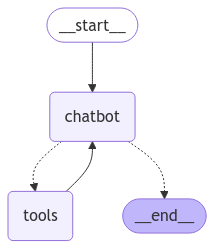

In [12]:
agent.display_graph()

In [35]:
agent.stream('delete test contact')

================================ Human Message =================================

delete test contact
================================== Ai Message ==================================
Tool Calls:
  delete_contact (48297946-c867-4f65-8808-bca452d6a96e)
 Call ID: 48297946-c867-4f65-8808-bca452d6a96e
  Args:
    resourceName: people/c891946763526538623
================================= Tool Message =================================
Name: delete_contact

successfully deleted contact
================================== Ai Message ==================================

OK. I've deleted Test Contact. Is there anything else I can do?


In [36]:
agent.get_state('messages')

[HumanMessage(content='show contacts', additional_kwargs={}, response_metadata={}, id='19ffd9b9-5773-4510-9533-c96075d723e5'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'show_contacts', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-75d1f2a7-b6cf-4757-8ef1-5eab9c5c0463-0', tool_calls=[{'name': 'show_contacts', 'args': {}, 'id': '0d2cfdb9-00e4-4850-b5fa-4684b572a4c6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2462, 'output_tokens': 3, 'total_tokens': 2465, 'input_token_details': {'cache_read': 0}}),
 ToolMessage(content="{'Tristan Padiou': {'resourcename': 'people/c1466543901560516172', 'etag': '%EgUBAi43PRoEAQIFByIMNlNpOVpQeGFIRXM9'}, 'John Doe': {'resourcename': 'people/c7610783302568859438', 'etag': '%EgUBAi43PRoEAQIFByIMQ0FaUnlQTWNqMUU9'}, 'Test Contact': {'resourcename': 'people/c8456743217438830401', 'etag': '%EgUBAi43PRoEAQIFByIMZWZ